# Modelos Series de Tiempo daily-total-female
Universidad del Valle de Guatemala
1. Pablo Gonzalez 20362
2. Javier Mombiela 20067

In [150]:
from Def_funciones import *

import pandas as pd
from numpy import mean
from numpy import median
from numpy import array
import matplotlib.pyplot as plt
from matplotlib import pyplot
import random
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error

#
from warnings import catch_warnings
from warnings import filterwarnings

# La librería statsmodel tiene implementaciones de SARIMA y de Holt-Winters
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Si el computador tiene procesadores múltiples, se aprovecharán
#from multiprocessing import cpu_count

from multiprocess import cpu_count
from joblib import Parallel

from joblib import delayed


In [151]:
data = pd.read_csv('data/daily-total-female-births.csv')
data.dtypes

Date      object
Births     int64
dtype: object

In [152]:
data.info


<bound method DataFrame.info of            Date  Births
0    1959-01-01      35
1    1959-01-02      32
2    1959-01-03      30
3    1959-01-04      31
4    1959-01-05      44
..          ...     ...
360  1959-12-27      37
361  1959-12-28      52
362  1959-12-29      48
363  1959-12-30      55
364  1959-12-31      50

[365 rows x 2 columns]>

In [153]:
data.shape

(365, 2)

In [154]:
pd.set_option('display.width',100)
pd.set_option('display.precision',3)
data.describe()

,Births
count,365.000
mean,41.981
std,7.348
min,23.000
25%,37.000
50%,42.000
75%,46.000
max,73.000


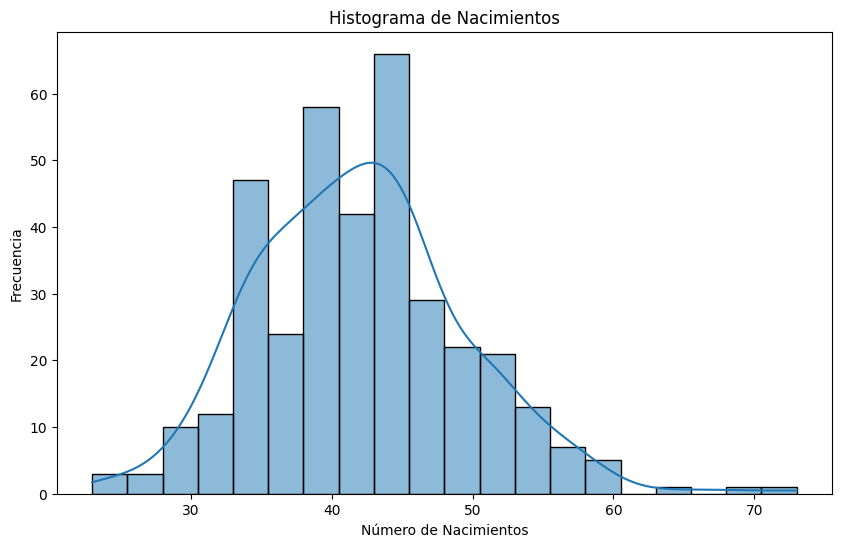

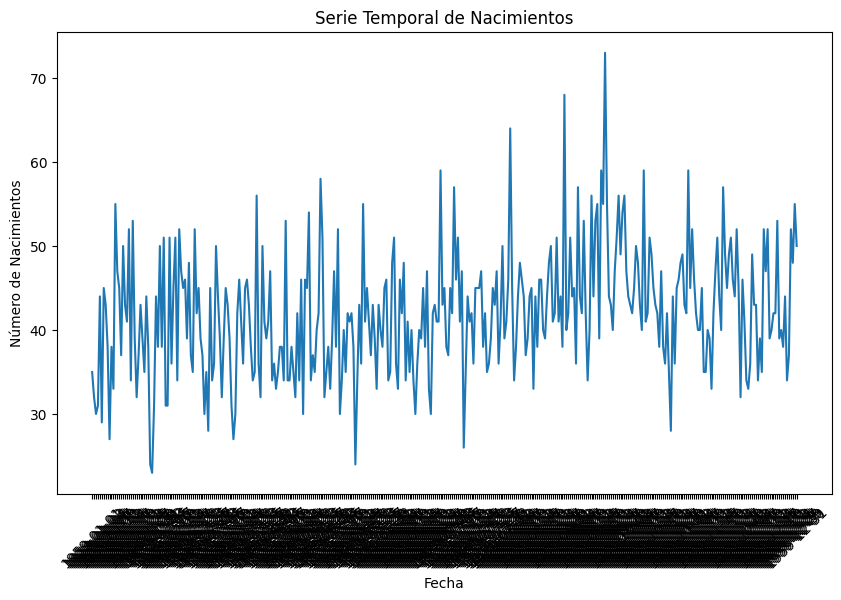

In [155]:

# Histograma de nacimientos
plt.figure(figsize=(10, 6))
sns.histplot(data["Births"], bins=20, kde=True)
plt.xlabel("Número de Nacimientos")
plt.ylabel("Frecuencia")
plt.title("Histograma de Nacimientos")
plt.show()

# Serie temporal de nacimientos
plt.figure(figsize=(10, 6))
sns.lineplot(x="Date", y="Births", data=data)
plt.xlabel("Fecha")
plt.ylabel("Número de Nacimientos")
plt.title("Serie Temporal de Nacimientos")
plt.xticks(rotation=45)
plt.show()

In [156]:
def division_entreno_prueba(datos, n_prueba):
    return datos[:-n_prueba], datos[-n_prueba:]

In [157]:
def medir_rmse(actual, predicho):
    return sqrt(mean_squared_error(actual, predicho))

In [158]:
def busqueda_malla(datos, lista_cfg, n_prueba, metodo = "sarima", paralelo = True):
    resultados = None
    if paralelo:
        # ejecutar las configuraciones en paralelo
        executor = Parallel(n_jobs = cpu_count(), backend = 'multiprocessing') 
        tareas = (delayed(calificar_modelo)(datos, n_prueba, metodo, cfg) for cfg in lista_cfg) 
        resultados = executor(tareas)
    else:
        resultados = [calificar_modelo(datos, n_prueba, metodo, cfg) for cfg in lista_cfg]
    # eliminar resultados vacíos
    resultados = [r for r in resultados if r[1] != None]
    return resultados

In [159]:
def validacion_al_frente(datos, n_prueba, metodo, cfg):
    predicciones = []
    # dividir el conjunto de datos
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    # grabar la historia con el conjunto de datos de entrenamiento
    historia = [x for x in entreno]
    # pasar por cada incremento de tiempo en el conjunto de prueba
    for i in range(len(prueba)):
        # ajustar el modelo a los datos y predecir los datos históricos
        if metodo == "promedio":
            yhat = prediccion_promedio(historia, cfg)
        elif metodo == "sarima":
            yhat = prediccion_sarima(historia, cfg)
        elif metodo == "exp":
            yhat = prediccion_alisamiento_exp(historia, cfg)
        # agregar el dato predicho en la lista de preducciones
        predicciones.append(yhat)
        # agregar la observación a la historia para la siguiente iteración
        historia.append(prueba[i])
    # estimar el error de las predicciones
    error = medir_rmse(prueba, predicciones)
    return [error, predicciones]

In [160]:
def calificar_modelo(datos, n_prueba, metodo, cfg, debug = False):
    resultado = None
    predicciones = None
    # convertir la confiuración a una llave
    llave = str(cfg)
    if debug:
        resultado, predicciones = validacion_al_frente(datos, n_prueba, metodo, cfg)
    else:
        # una falla durante la validación del modelo sugiere una configuración inestable
        try:
        # nunca mostrar advertencias cuando se busca en malla...demasiado "ruido"
            with catch_warnings():
                filterwarnings("ignore")
                resultado, predicciones = validacion_al_frente(datos, n_prueba, metodo, cfg)
        except:
            error = None
    if resultado is not None:
        print(f' > Modelo{llave} {resultado:.3f}')
    return (llave, resultado, predicciones)

In [161]:
def encontrar_mejor_solucion(series, nombre, metodo = "sarima", muestra = False):
    datos = series.values
    resultados = []
    # dividir los datos
    n_prueba = int(len(datos) * 0.2) # porcenta usado para prueba
    long_max = len(datos) - n_prueba
    print(f"Tamaño Entrenamiento {long_max}")
    print(f"Tamaño Prueba {n_prueba}")

    # configuraciones de los modelos
    if metodo == "sarima":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_sarima()
    elif metodo == "promedio":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_simple(long_max)
    elif metodo == "exp":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_alisamiento_exp()
        datos = datos[:,0]
    # muestrear algunos
    if muestra:
        lista_cfg_azar = random.sample(lista_cfg, k = 25)
        while len(resultados) < 5:
            lista_cfg_azar = random.sample(lista_cfg, k = 25)
            resultados += busqueda_malla(datos, lista_cfg_azar, n_prueba, metodo)
    else:
        # búsqueda en malla
        resultados = busqueda_malla(datos, lista_cfg, n_prueba, metodo)
        
    
    # ordenan las configuraciones por error, ascendente
    resultados.sort(key = lambda tup: tup[1])


    print('terminado')
    # listar las mejores 3 configuraciones
    for cfg, error, predicciones in resultados[:3]:
        print(cfg, error)

    # desplegar
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    prediccion = pd.DataFrame(list(entreno.flatten()) + resultados[0][2])
    ax = pd.DataFrame(datos).plot(label = "Original") # Datos originales
    prediccion.plot(ax = ax, alpha = .7, figsize = (14,7))
    # Esconder las líneas de malla de la gráfica
    # ax.grid(False)

    # Esconder las marcas en los ejes
    #ax.set_xticks([])
    #ax.set_yticks([])
    
    plt.savefig(f"{nombre}_{metodo}.png", transparent = True)
    plt.show()

In [162]:
def config_simple(long_max, offsets = [1]):
    configs = []
    for i in range(1, long_max + 1):
        for t in ['mediana',"promedio"]:
            cfg = [i, t]
            configs.append(cfg)
    return configs

# prediccion de un paso por promedio
def prediccion_promedio(historia, config):
    n, tipo_promedio = config
    if tipo_promedio == 'promedio':
        return mean(historia[-n:])
    return median(historia[-n:])

In [163]:
def prediccion_sarima(historia, config):
    orden, orden_estacional, tendencia = config
    # definir el modelo
    modelo = SARIMAX(historia, order = orden, seasonal_order = orden_estacional, trend = tendencia,
      enforce_stationarity = False, enforce_invertibility = False)
    # ajustar el model con los datos
    modelo_ajustado = modelo.fit(disp = False)
    # hacer la predicción de un paso
    yhat = modelo_ajustado.predict(len(historia), len(historia))
    return yhat[0]

def config_sarima(estacional=[0]):
    modelos = []
    # definir las listas de configuración
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n', 'c', 't', 'ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]

    # Si m es mayor que cero, generar configuraciones estacionales
    m_params = estacional

    # crear instancias de configuración
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p, d, q), (P, D, Q, m), t]
                                    modelos.append(cfg)
    return modelos


In [454]:
def prediccion_alisamiento_exp(historia, configuracion):
    # Crear una serie de tiempo a partir de la historia
    serie_tiempo = pd.Series(historia)
    
    # Aplicar el modelo de Holt-Winters exponencial
    modelo = ExponentialSmoothing(serie_tiempo, 
                                  trend=configuracion[0], 
                                  seasonal=configuracion[1], 
                                  seasonal_periods=configuracion[2])
    
    # Ajustar el modelo a los datos históricos
    modelo_ajustado = modelo.fit()
    
    # Realizar una predicción de un paso hacia adelante
    prediccion = modelo_ajustado.forecast(steps=1)
    
    return prediccion[0]

def config_alisamiento_exp(estacional = [None]): 
    modelos = []
    # definir las listas de config
    t_params = ['add', 'mul', None]
    d_params = [True, False] 
    s_params = ['add', 'mul', None]
    p_params = estacional
    b_params = [True, False]
    r_params = [True, False]
    # crear instancias de configuración
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            modelos.append(cfg)
    return modelos

### Promedio

Tamaño Entrenamiento 292
Tamaño Prueba 73
Mse:  7.698959189574895


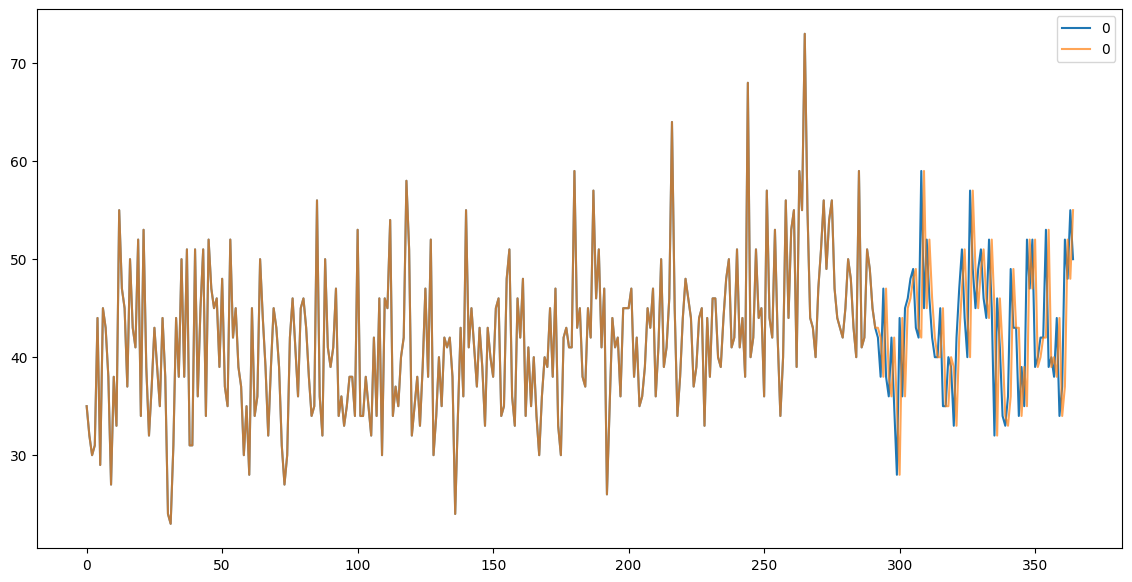

In [165]:
series = pd.read_csv('./data/daily-total-female-births.csv', header = 0, index_col = 0)
datos = series.values
n_prueba = int(len(datos) * 0.2)
long_max = len(datos) - n_prueba
print(f"Tamaño Entrenamiento {long_max}")
print(f"Tamaño Prueba {n_prueba}")
cfg = config_simple(long_max)[1]
entreno, prueba = division_entreno_prueba(datos, n_prueba)
historia = [x for x in entreno]
predicciones = []
for i in range(len(prueba)):
    yhat = prediccion_promedio(historia, cfg)
    predicciones.append(yhat)
    historia.append(prueba[i])

error = medir_rmse(prueba, predicciones)
print("Mse: ",error)

prediccion = pd.DataFrame(list(entreno.flatten()) + predicciones)


ax = pd.DataFrame(datos).plot(label = "Original") # Datos originales
prediccion.plot(ax = ax, alpha = .7, figsize = (14,7))

nombre = "daily-total-female-births"
metodo = "promedio"
    
plt.savefig(f"{nombre}_{metodo}.png", transparent = True)
plt.show()


### Sarima

In [214]:
datos = series.values
n_prueba = 100
long_max = len(datos) - n_prueba

lista_cfg = config_sarima()
print(f"Tamaño Entrenamiento {long_max}")
print(f"Tamaño Prueba {n_prueba}")

entreno, prueba = division_entreno_prueba(datos, n_prueba)
historia = [x for x in entreno]
predicciones = []

lista_cfg =  random.sample(lista_cfg, k = 5)
for cfg in lista_cfg:
    for i in range(len(prueba)):
        try:
            with catch_warnings():
                yhat = prediccion_sarima(historia, cfg)
                predicciones.append(yhat)
                historia.append(prueba[i])
        except:
            error = None

# Keep only the non-empty predictions

error = sqrt(mean_squared_error(prueba, predicciones))

Tamaño Entrenamiento 265
Tamaño Prueba 100


c:\Users\pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

MSE: 7.860295226510355


<AxesSubplot: >

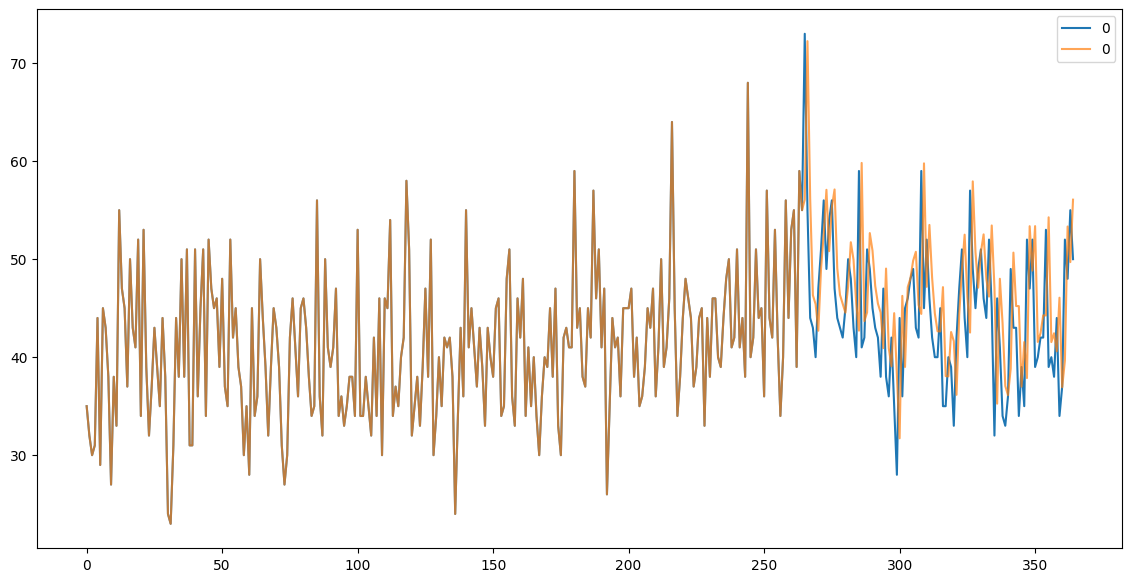

In [215]:
print("MSE:", error)

prediccion = pd.DataFrame(list(entreno.flatten()) + predicciones)
ax = pd.DataFrame(datos).plot(label = "Original") # Datos originales

prediccion.plot(ax = ax, alpha = .7, figsize = (14,7))

### Alisamiento Exponencial

c:\Users\pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


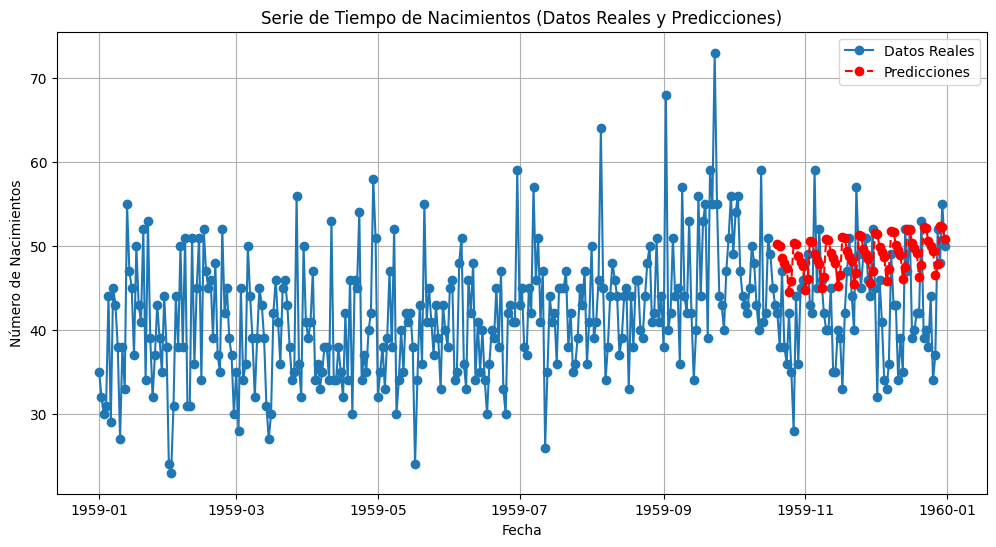

RMSE: 8.894679505435024


In [464]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import numpy as np

# Cargar los datos desde el archivo CSV
df = pd.read_csv('./data/daily-total-female-births.csv')

# Convertir la columna 'Date' en un objeto datetime
df['Date'] = pd.to_datetime(df['Date'])

# Establecer la columna 'Date' como índice
df.set_index('Date', inplace=True)

# Dividir el conjunto de datos en entrenamiento y prueba (por ejemplo, 80% entrenamiento, 20% prueba)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Aplicar el modelo de alisamiento exponencial al conjunto de entrenamiento
modelo = ExponentialSmoothing(train['Births'], trend='add', seasonal='add', seasonal_periods=7)
resultado = modelo.fit()

# Hacer predicciones en el conjunto de prueba
predicciones = resultado.forecast(steps=len(test))  # Predicción para la longitud del conjunto de prueba

# Visualizar las predicciones y el conjunto de prueba
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Births'], marker='o', linestyle='-', label='Datos Reales')
plt.plot(test.index, predicciones, marker='o', linestyle='--', color='red', label='Predicciones')
plt.legend()
plt.title('Serie de Tiempo de Nacimientos (Datos Reales y Predicciones)')
plt.xlabel('Fecha')
plt.ylabel('Número de Nacimientos')
plt.grid(True)
plt.show()

# Calcular el RMSE
rmse = np.sqrt(mean_squared_error(test['Births'], predicciones))
print("RMSE:", rmse)


### Prophet

In [490]:
series = pd.read_csv('./data/daily-total-female-births.csv', header=0, index_col=None)
series['ds']  = pd.to_datetime(series['Date'])
series[['y']] = series[['Births']].astype(float)
series = series[["ds","y"]]
series.head()


,ds,y
0,1959-01-01,35.0
1,1959-01-02,32.0
2,1959-01-03,30.0
3,1959-01-04,31.0
4,1959-01-05,44.0


In [491]:
modelo = Prophet(mcmc_samples = 500, seasonality_mode = 'multiplicative').fit(series)

12:35:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |██▊       | 00:00 Iteration:   1 / 500 [  0%]  (Warmup)
chain 1 |████▎     | 00:00 Iteration: 100 / 500 [ 20%]  (Warmup)

chain 1 |█████▋    | 00:01 Iteration: 200 / 500 [ 40%]  (Warmup)



chain 1 |███████▏  | 00:01 Iteration: 251 / 500 [ 50%]  (Sampling)


chain 1 |████████▌ | 00:02 Iteration: 350 / 500 [ 70%]  (Sampling)


chain 1 |██████████| 00:02 Iteration: 450 / 500 [ 90%]  (Sampling)


chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


12:35:11 - cmdstanpy - INFO - CmdStan done processing.
12:35:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id

In [492]:
futuro = modelo.make_future_dataframe(periods = 48, freq = "M")
predicciones_Prophet = modelo.predict(futuro)
predicciones_Prophet[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
408,1963-08-31,17.801,-94.439,122.900
409,1963-09-30,17.202,-99.859,126.227
410,1963-10-31,17.374,-107.262,130.363
411,1963-11-30,16.110,-108.827,127.670
412,1963-12-31,16.440,-115.394,139.875


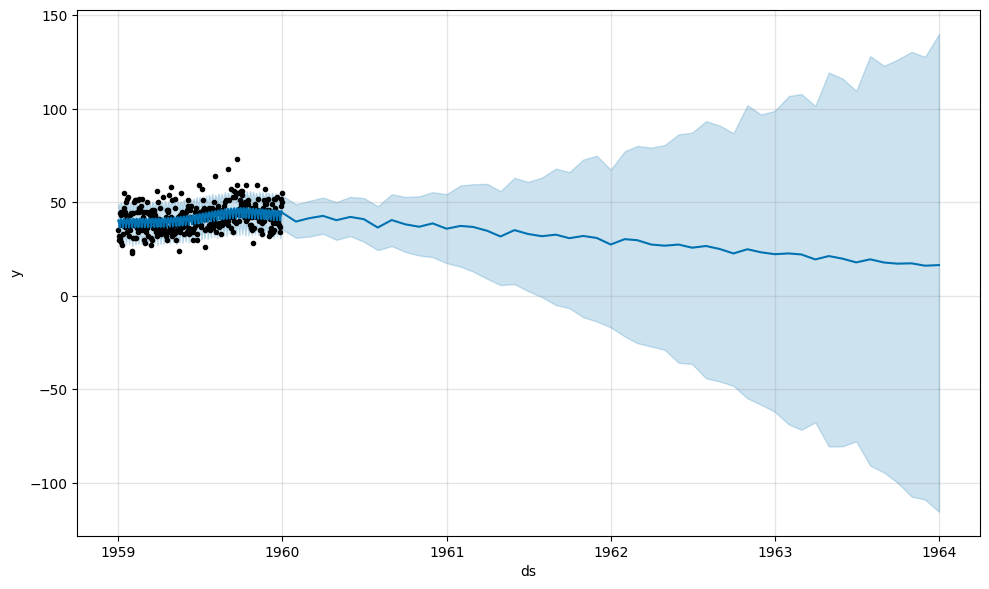

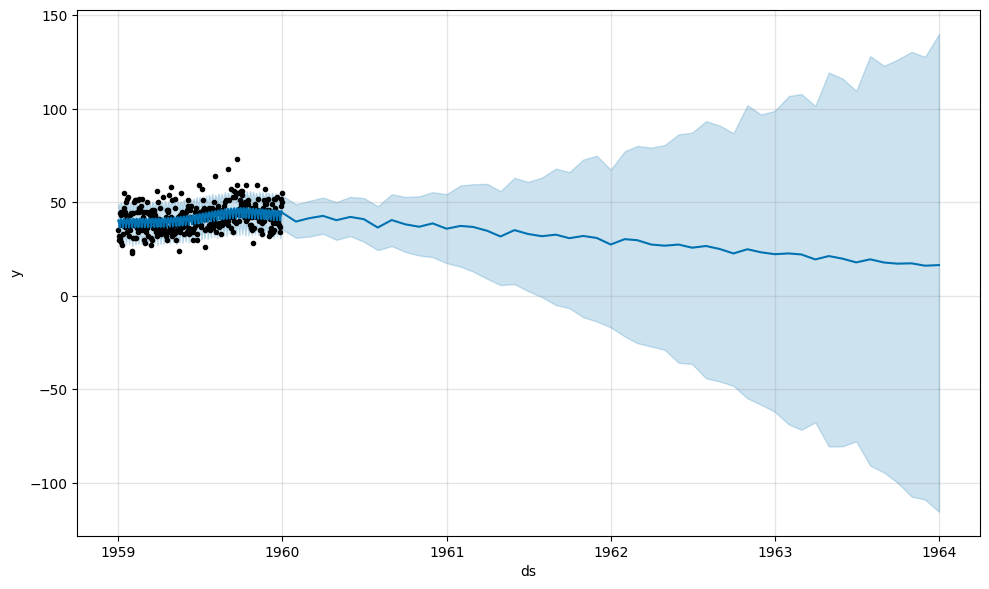

In [493]:
modelo.plot(predicciones_Prophet)

In [494]:
error = sqrt(mean_squared_error(series['y'], predicciones_Prophet['yhat'][0:365]))
print("MSE:", error)

MSE: 6.752236349501501


### Redes Neuronales

In [503]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from matplotlib import pyplot
%matplotlib inline  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [504]:
def series_a_supervisado(datos, n_entrada, n_salida = 1):
	df = DataFrame(datos)
	cols = []
	# secuencia de entrada (t-n, ... t-1)
	for i in range(n_entrada, 0, -1):
		cols.append(df.shift(i))
	# secuencia predicha (t, t+1, ... t+n)
	for i in range(0, n_salida):
		cols.append(df.shift(-i))
	# juntarlo todo
	agg = concat(cols, axis = 1)
	# botar columnas con valores NaN
	agg.dropna(inplace = True)
	return agg.values

In [505]:
def ajustar_modelo(entreno, config):
	# desempacar la configuración
	n_entrada, n_nodos, n_epocas, n_tandas = config
    #[24, 500, 100, 100]
    # preparar los datos
	datos = series_a_supervisado(entreno, n_entrada)
	entreno_x, entreno_y = datos[:, :-1], datos[:, -1]
	# definir el modelo
	modelo = tf.keras.Sequential()
	modelo.add(tf.keras.layers.Dense(n_nodos, activation='relu', input_dim = n_entrada))
	modelo.add(tf.keras.layers.Dense(1))
	modelo.compile(loss='mse', optimizer='adam')
	# ajustar
	modelo.fit(entreno_x, entreno_y, epochs = n_epocas, batch_size = n_tandas, verbose = 0)
	return modelo

In [506]:
def prediccion_modelo(modelo, historia, config):
	# desempacar la configuración
	n_entrada, _, _, _ = config
	# preparar los datos
	x_entrada = array(historia[-n_entrada:]).reshape(1, n_entrada)
	# predecir
	yhat = modelo.predict(x_entrada, verbose = 0)
	return yhat[0]

In [507]:
def validacion_al_frente(datos, n_prueba, cfg):
    predicciones = []
    # dividir el conjunto de datos
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    # ajustar el modelo
    modelo = ajustar_modelo(entreno, cfg)
    # grabar la historia con el conjunto de datos de entrenamiento
    historia = [x for x in entreno]
    # pasar por cada incremento de tiempo en el conjunto de prueba
    for i in range(len(prueba)):
        # ajustar el modelo a los datos y predecir los datos históricos
        yhat = prediccion_modelo(modelo, historia, cfg)
        # agregar el dato predicho en la lista de preducciones
        predicciones.append(yhat)
        # agregar la observación a la historia para la siguiente iteración
        historia.append(prueba[i])
    # estimar el error de las predicciones
    error = medir_rmse(prueba, predicciones)
    print(f' > {error:.3f}')
    return [error, predicciones]

In [508]:
def evaluacion_iter(datos, config, n_prueba, n_repeticiones = 5):
	# ajustar y evaluar el modelo n veces
    resultados = []
    predicciones = []
    for _ in range(n_repeticiones):
        resultados_temp, predicciones_temp = validacion_al_frente(datos, n_prueba, config)
        resultados.append(resultados_temp)
        predicciones.append(predicciones_temp)
    return [resultados, predicciones]

In [509]:
def resumir_resultados(nombre, resultados):
	# imprimir un resúmen
	media_result, std_result = mean(resultados), std(resultados)
	print(f'{nombre}: {media_result:.3f} RMSE (+/- {std_result:.3f})')
	# gráficas de caja y bigotes
	pyplot.boxplot(resultados)
	pyplot.show()

In [510]:
def buscar_mejor_solucion(series, nombre, metodo = "red neuronal"):
    datos = series.values
    n_prueba = int(len(datos)*0.2) # porcentaje utilizado para prueba
    config = [24, 500, 100, 100]
    resultados, predicciones = evaluacion_iter(datos, config, n_prueba)
    resumir_resultados('mlp', resultados)
    plt.savefig("resultados_{nombre}_{metodo}.png")
    plt.show()
    entreno, prueba = division_entreno_prueba(datos,n_prueba)
    prediccion = pd.DataFrame(list(entreno.flatten()) + np.array(predicciones[0]).flatten().tolist())
    ax = pd.DataFrame(datos).plot(label="Original") # datos originales
    prediccion.plot(ax=ax, alpha=.7, figsize=(14,7))
    plt.savefig("pred_{nombre}_{metodo}.png")
    plt.show()

 > 6.639
 > 6.918
 > 7.061
 > 6.821
 > 6.775
mlp: 6.843 RMSE (+/- 0.141)


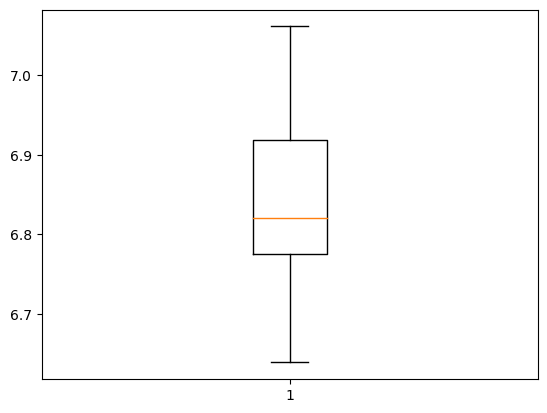

<Figure size 640x480 with 0 Axes>

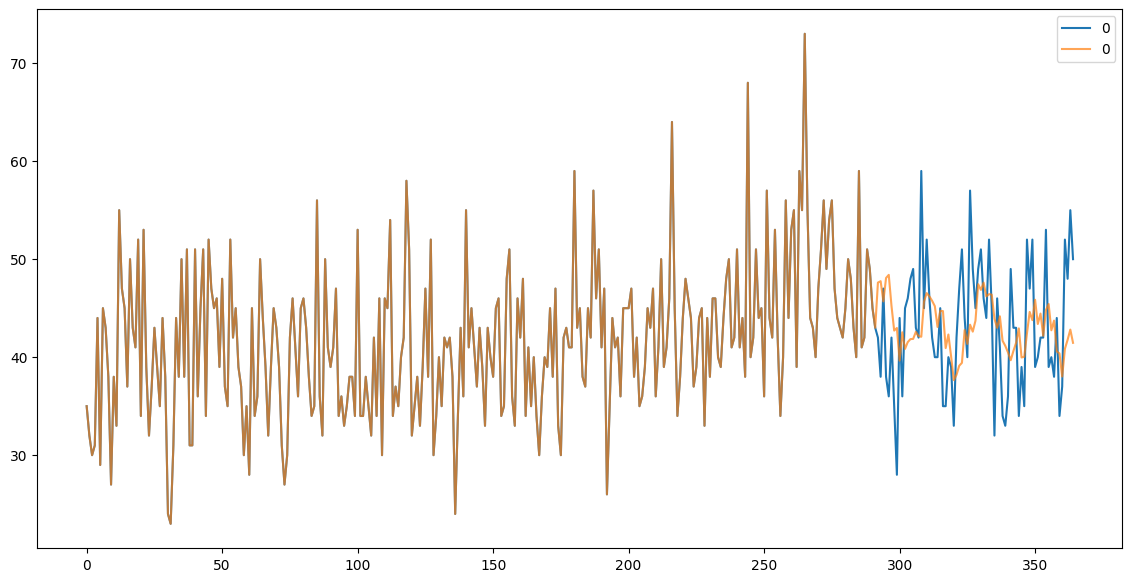

In [511]:
series = pd.read_csv('./data/daily-total-female-births.csv', header=0,index_col=0)
buscar_mejor_solucion(series,"nacimientos")

### Discusión de Resultados


1. **Promedio (Media Simple):**
   - El modelo de promedio simple se utiliza como línea de base para comparar otros modelos.
   - Este modelo asume que los valores futuros serán iguales al promedio de los valores históricos.
   - El RMSE indica que este modelo tiene un rendimiento moderado, pero puede no capturar patrones estacionales o tendencias.

2. **SARIMA :**
   - El modelo SARIMA (Seasonal Autoregressive Integrated Moving Average) es una extensión del modelo ARIMA que incluye términos estacionales.
   - A pesar de su capacidad para capturar patrones estacionales, el RMSE es ligeramente superior al del modelo de promedio simple.
   - Podría ser una buena elección si tus datos tienen una fuerte estacionalidad.

3. **Alisamiento Exponencial:**
   - El alisamiento exponencial es una técnica que se utiliza para suavizar los datos y generar pronósticos.
   - Aunque tiene un RMSE más alto que otros modelos, sigue siendo útil cuando se trata de suavizar series de tiempo irregulares.
   - No captura patrones estacionales de manera efectiva, por lo que su rendimiento puede ser inferior en series de tiempo estacionales.

4. **Prophet :**
   - Prophet es una herramienta de pronóstico desarrollada por Facebook que maneja automáticamente tendencias, estacionalidades y días festivos.
   - Tiene un RMSE más bajo en comparación con los otros modelos, lo que sugiere un rendimiento más preciso en tus datos.
   - Es una excelente opción cuando tienes datos con patrones estacionales y tendencias.

5. **Red Neuronal:**
   - Las redes neuronales son modelos de aprendizaje profundo que pueden capturar relaciones no lineales en los datos.
   - El RMSE es competitivo con Prophet, lo que indica un buen rendimiento.
   - Este modelo es prometedor, especialmente si tus datos son altamente no lineales y complejos.

**Conclusión:**
- Basándonos en los valores de RMSE proporcionados, tanto Prophet es el modelo que tienen el rendimiento más bajo, lo que sugiere que es el más precisos para nuestros datos.
- Prophet es especialmente útil cuando tienes datos con patrones estacionales y tendencias, ya que puede manejarlos de manera automática.


